In [11]:
import numpy as np
import math as math
#import random as pyrandom
#from scipy import spatial

# Функция переводит считываемый .txt файл (аргумент str)
# без первой строчки (не содержащей данных) в список python 
# (обект типа list); аргумент m отвечает за то, 
# сколько в начале идет переменных int-типа; аргумент M был введен,
# чтобы не считывать не нужную информацию 
def rd(str,m = 100, M = 100):
    with open(str) as f:
        polyShape = []
        k = 0
        for line in f:
            if k > 0:
                line = line.strip()
                line = line.split(",")
                newline = line[:min(M,len(line))] # to deal with blank 
                if newline:            # lines (ie skip them)
                    newline = [float(i) for i in newline]
                    l = len(newline)
                    ml = min(l,m)
                    for i in range(0,ml):
                        newline[i] = int(newline[i])
                    polyShape.append(newline + line[min(M,len(newline)):])
            k = k + 1
    return polyShape

# atoms.txt Содержит информацию об атомах, в колонках следующие данные:
# ID, x, y, z, сигма, эпсилон, заряд, 
# радиус Ван-дер-Ваальса, объём и еще две колонки типа строки; 
# радиус и объем и эти две колонки не используются далее
atomsH = rd('./H1za3/atoms.txt',1,9) # вместо 9 можно было и 7 взять ... _out200.csv
atomsL = rd('./L1za3/atoms.txt',1,9)

#bonds.txt Содержит информацию о связях, структура файла:
# ID1, ID2, Kr, r0
bondsH = rd('./H1za3/bonds.txt',2)
bondsL = rd('./L1za3/bonds.txt',2)


# angles.txt Содержит информацию об углах, структура файла:
# ID1, ID2, ID3, Kt, theta0
anglesH = rd('./H1za3/angles.txt',3)
anglesL = rd('./L1za3/angles.txt',3)

# dihedrals.txt Содержит информацию о двугранных углах, структура:
# ID1, ID2, ID3, ID4, V1, V2, V3, V4
# Все константы V1, V2, V3, V4 разделены на два, 
# при вычислении энергии делить их на два НЕ НАДО.
dihedralsH = rd('./H1za3/dihedrals.txt',4)
dihedralsL = rd('./L1za3/dihedrals.txt',4)

# neighbours.txt, two_bonds_neigh.txt, three_bonds_neigh.txt
# Содержат информацию о соседях непосредственных, 
# второго и третьего порядка соответственно. 
# У всех одна и та же структура:
# ID    id_1 id_2 ... id_n
# ID – индекс атома, id_1 id_2 ... id_n – индексы его соседей.
neighboursH = rd('./H1za3/neighbours.txt')
neighboursL = rd('./L1za3/neighbours.txt')
two_bonds_neighH = rd('./H1za3/two_bonds_neigh.txt')
two_bonds_neighL = rd('./L1za3/two_bonds_neigh.txt')
three_bonds_neighH = rd('./H1za3/three_bonds_neigh.txt')
three_bonds_neighL = rd('./L1za3/three_bonds_neigh.txt')

# По координатам 4-х точек рассчитывается косинус диэдрального угла, ими образованного
def dihedral(v1,v2,v3,v4):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    vm = (v2 + v3)/2
    vm1 = v1 - vm
    vm4 = v4 - vm
    v23 = v3 - v2
    sp1 = vm1 - v23*(vm1.dot(v23)/v23.dot(v23))
    sp2 = vm4 - v23*(vm4.dot(v23)/v23.dot(v23))
    cos = sp1.dot(sp2)/(np.linalg.norm(sp1)*np.linalg.norm(sp2))
    return cos

# По координатам 3-х точек рассчитывается угл, ими образованный
def angle(v1,v2,v3):
    vv1 = np.array(v1) - np.array(v2)
    vv2 = np.array(v3) - np.array(v2)
    cos = vv1.dot(vv2)/(np.linalg.norm(vv1)*np.linalg.norm(vv2))
    acos = np.arccos(cos)
    return acos

# Расчитываются константы f_ij в E_{nonbonded}
def f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j):
    for idx in neighbours[i]:
        if idx == j:
            return 0
    for idx in two_bonds_neigh[i]:
        if idx == j:
            return 0
    for idx in three_bonds_neigh[i]:
        if idx == j:
            return 0.5
    return 1

# Далее вычисляются отдельные составляющие OPLS force field
def E_dihedral(atoms, dihedrals):
    N = len(dihedrals)
    E = 0
    for k in range(0,N):
        cos = dihedral(atoms[dihedrals[k][0]][1:4],atoms[dihedrals[k][1]][1:4],atoms[dihedrals[k][2]][1:4],atoms[dihedrals[k][3]][1:4])
        E = E + dihedrals[k][4]*(1 + cos)
        E = E + 2*dihedrals[k][5]*(1 - pow(cos,2))
        E = E + dihedrals[k][6]*(1 + 4*pow(cos,3) - 3*cos)
        E = E + 8*dihedrals[k][7]*(pow(cos,2) - pow(cos,4))
    return E * 4.184

def E_angle(atoms,angles):
    N = len(angles)
    E = 0
    for k in range(0,N):
        E = E + angles[k][3]*pow(angle(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4]) - angles[k][4],2)
    return E * 4.184

def E_bonds(atoms,bonds):
    N = len(bonds)
    E = 0
    for k in range(0,N):
        r = np.array(atoms[bonds[k][0]][1:4]) - np.array(atoms[bonds[k][1]][1:4])  
        E = E + bonds[k][2]*pow(np.linalg.norm(r) - bonds[k][3],2)
    return E * 4.184

# 1389.38757 – константа, учитывающая 1/(4πε0), множитель 10^(-10) 
# – перевод ангстремов в метры,
# заряды электронов и перевод ккал/моль в кДж/моль
def E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    E = 0
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                E = E + f * atoms[i][6] * atoms[j][6] / np.linalg.norm(r)
    return E * 1389.38757

# Электростатическая составляющая энергии взаимодействия антитела H и леганда L
def E_elst_p(atomsH, atomsL):
    NH = len(atomsH)
    NL = len(atomsL)
    E = 0
    for i in range(0,NH):
        for j in range(0,NL):
            r = np.array(atomsH[i][1:4]) - np.array(atomsL[j][1:4])
            E = E + atomsH[i][6] * atomsL[j][6] / np.linalg.norm(r)
    return E * 1389.38757

# Для получения формулы из Википедии https://en.wikipedia.org/wiki/OPLS:
# Раскрыть скобки и подставить
# A = eps * (sig ^ 6)
# C = eps * (sig ^ 3)
# Формула переделана для уменьшения числа арифметических операций 
# и соответствия параметрам, которые предоставляет OPLS
# 4 * 4.184 – перевод ккал/моль в кДж/моль
def E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    E = 0
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                eps = math.sqrt(atoms[i][5] * atoms[j][5])
                sig = atoms[i][4] * atoms[j][4]
                dist = np.linalg.norm(np.array(atoms[i][1:4]) - np.array(atoms[j][1:4]))
                sigSqDivR = (sig / dist ** 2) ** 3
                E = E + f * eps * sigSqDivR * (sigSqDivR - 1)
    return E * 4 * 4.184

# Ван-дер-Ваальсовская составляющая энергии взаимодействия антитела H и леганда L
def E_vdw_p(atomsH, atomsL):
    NH = len(atomsH)
    NL = len(atomsL)
    E = 0
    for i in range(0,NH):
        for j in range(0,NL):
            eps = math.sqrt(atomsH[i][5] * atomsL[j][5])
            sig = atomsH[i][4] * atomsL[j][4]
            dist = np.linalg.norm(np.array(atomsH[i][1:4]) - np.array(atomsL[j][1:4]))
            sigSqDivR = (sig / dist ** 2) ** 3
            E = E + eps * sigSqDivR * (sigSqDivR - 1)
    return E * 4 * 4.184


def E(atomsH, atomsL, dihedralsH, dihedralsL, anglesH, anglesL,\
      bondsH, bondsL, neighboursH, neighboursL,\
      two_bonds_neighH, two_bonds_neighL,\
      three_bonds_neighH, three_bonds_neighL):
    E = E_dihedral(atomsH, dihedralsH) + E_dihedral(atomsL, dihedralsL) +\
    E_angle(atomsH,anglesH) + E_angle(atomsL,anglesL)+\
    E_bonds(atomsH,bondsH) +  E_bonds(atomsL,bondsL) +\
    E_elst(atomsH, neighboursH, two_bonds_neighH, three_bonds_neighH) +\
    E_elst(atomsL, neighboursL, two_bonds_neighL, three_bonds_neighL) +\
    E_vdw(atomsH, neighboursH, two_bonds_neighH, three_bonds_neighH) +\
    E_vdw(atomsL, neighboursL, two_bonds_neighL, three_bonds_neighL) +\
    E_elst_p(atomsH, atomsL) + E_vdw_p(atomsH, atomsL)
    return E


print(E(atomsH, atomsL, dihedralsH, dihedralsL, anglesH, anglesL,\
      bondsH, bondsL, neighboursH, neighboursL,\
      two_bonds_neighH, two_bonds_neighL,\
      three_bonds_neighH, three_bonds_neighL))

-14841.7501723


[ 0.59514491  0.48351059 -0.64188787]


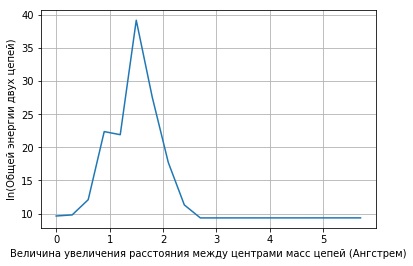

In [12]:
def CenMas(atoms):
    N = len(atoms)
    v = np.array([0., 0., 0.])
    for k in range(0,N):
        for coor in range(0,3):
            v[coor] = v[coor] + atoms[k][coor + 1]
    vv = v/N
    return vv
    
v = CenMas(atomsH) - CenMas(atomsL)    
#print(np.linalg.norm(v))
v = np.array(v) / np.linalg.norm(v)
print(v)
lH = len(atomsH)
#v = v/pow(lH,1/2)
hh = 0.3
M = 20
mmm = []
ccc = []
atoms_old = atomsH
#print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh))
for k in range(0,M):
    for nm in range(0,lH):
        for coor in range(0,3):
            atomsH[nm][coor + 1] = atoms_old[nm][coor + 1] + k*v[coor]*hh
    EE = E(atomsH, atomsL, dihedralsH, dihedralsL, anglesH, anglesL,\
      bondsH, bondsL, neighboursH, neighboursL,\
      two_bonds_neighH, two_bonds_neighL,\
      three_bonds_neighH, three_bonds_neighL)
    mmm.append(np.log(EE + 30000))
    ccc.append(k*hh)  

import matplotlib.pyplot as plt
plt.plot(ccc,mmm)
plt.ylabel(r"ln(Общей энергии двух цепей)")
plt.xlabel(r"Величина увеличения расстояния между центрами масс цепей (Ангстрем)")
plt.grid(True)
plt.show()